# FastText - Sorting with Cosine Distance Algo

by FastText - Sorting with Cosine Distance


https://www.kaggle.com/code/ilyaryabov/fasttext-sorting-with-cosine-distance-algo

[1. Data](#data) 
- [Ordered notebook data](https://www.kaggle.com/datasets/ilyaryabov/correctly-ordered-notebooks-for-google-ai4code)
    - Correctly ordered notebooks
    - ![](../input/correctly-ordered-notebooks-for-google-ai4code/example.jpeg)
- [Model](https://www.kaggle.com/datasets/ilyaryabov/fasttext-model-for-google-ai4code)
    - Specifically pre-trained for Google AI4Code on the whole dataset - around 140000 preprocessed files

[2. Train model](#train-model)
- [FastText model](https://www.kaggle.com/ilyaryabov/fasttext-public-model-teaching)
    - Describes how to create a fasttext model
    
[3. Apply model](#apply-model)
    


<a id="train-model"></a>
## 2. Train model

In [1]:
import numpy as np
import pandas as pd
import os
import re
import fasttext
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer

In [2]:
src = '/kaggle/input/AI4Code/'
dataset_path = '/kaggle/input/correctly-ordered-notebooks-for-google-ai4code/dataset/dataset/'# train-orders.csv 의 순서대로 노트북파일을 재구성한 데이터

In [3]:
stemmer = WordNetLemmatizer() # 표제어 추출 도구

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # https://wikidocs.net/4308
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        #return document

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    
def preprocess_df(df):
    """
    This function is for processing sorce of notebook
    returns preprocessed dataframe
    """
    return [preprocess_text(message) for message in df.source]


In [4]:
# (참고)str & bytes datatype
my_string  = 'A new string'
print(type(my_string))

my_string_one = b'A new string'
print(type(my_string_one))

<class 'str'>
<class 'bytes'>


In [5]:
# There were experiments with 
# N = 10000 (7~% of dataset) and 
# N = 140000 (100% of dataset)
# They gave approximattly the same result

N = 1500

sourses = []
print('searching files...')
files = os.listdir(dataset_path)[:N]
print('reading files...')
dfs = [pd.read_csv(dataset_path + file) for file in tqdm(files)]
# print('processing files...')
# sourses = [preprocess_df(df) for df in tqdm(dfs)]

searching files...
reading files...


100%|██████████| 1500/1500 [00:15<00:00, 94.25it/s]


In [6]:
# 모델 학습을 위한 txt 파일 생성
processed_data = "preprocessed_messages.txt"
print('creating txt file...')
with open(processed_data, "w") as fout:
    for notebook in tqdm(dfs):
        for i in range(len(notebook)):
            fout.write('{}\n'.format( preprocess_text(notebook.source[i])) )
            #print(notebook.source[i])
    fout.close()

creating txt file...


100%|██████████| 1500/1500 [00:26<00:00, 57.48it/s]


In [7]:
# # text data 확인
# with open(processed_data) as f:
#     proccessed_text = f.readlines()
# proccessed_text

In [8]:
# # preprocessed data 확인
# notebook = dfs[0]
# for i in range(len(notebook)):
# #     fout.write('{}\n'.format( preprocess_text(notebook.source[i])) )
#     print(i)
#     print(notebook.source[i])
#     print(preprocess_text(notebook.source[i]))
#     print(sourses[0][i])

In [9]:
print('teaching model...')
model = fasttext.train_unsupervised(input = processed_data)

# parameters(default)
# input             # training file path (required)
# model             # unsupervised fasttext model {cbow, skipgram} [skipgram]
# lr                # learning rate [0.05]
# dim               # size of word vectors [100]
# ws                # size of the context window [5]
# epoch             # number of epochs [5]
# minCount          # minimal number of word occurences [5]
# minn              # min length of char ngram [3]
# maxn              # max length of char ngram [6]
# neg               # number of negatives sampled [5]
# wordNgrams        # max length of word ngram [1]
# loss              # loss function {ns, hs, softmax, ova} [ns]
# bucket            # number of buckets [2000000]
# thread            # number of threads [number of cpus]
# lrUpdateRate      # change the rate of updates for the learning rate [100]
# t                 # sampling threshold [0.0001]
# verbose           # verbose [2]

teaching model...


Read 1M words
Number of words:  22195
Number of labels: 0
Progress: 100.0% words/sec/thread:   50242 lr:  0.000000 avg.loss:  1.380597 ETA:   0h 0m 0s


In [10]:
print('saving model...')
model.save_model(f'model{N}.bin')
print('DONE')

saving model...
DONE


In [11]:
# from zipfile import ZipFile
# ZipFile('model.zip', mode='w').write(f'model{N}.bin')

In [12]:
# !rm preprocessed_messages.txt
# !rm model*.bin

<a id="apply-model"></a>
## 3. Apply model

The following notebook describes an algorithm for sorting cells using cosine distance in vector space

In [13]:
import numpy as np
import pandas as pd
import os
import re
import fasttext
fasttext.FastText.eprint = lambda x: None

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from pathlib import Path

pd.options.display.max_rows = 100

In [14]:
src = '/kaggle/input/AI4Code/'
data_dir = Path('../input/AI4Code')
fasttext_model = '/kaggle/input/fasttext-model-for-google-ai4code/model140000.bin' # 140000 data로 학습시킨 모델

In [15]:
# src = '../input/AI4Code/'
train_orders_df = pd.read_csv(src + 'train_orders.csv')
train_orders_df

,id,cell_order
0,00001756c60be8,1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...
1,00015c83e2717b,2e94bd7a 3e99dee9 b5e286ea da4f7550 c417225b 5...
2,0001bdd4021779,3fdc37be 073782ca 8ea7263c 80543cd8 38310c80 0...
3,0001daf4c2c76d,97266564 a898e555 86605076 76cc2642 ef279279 d...
4,0002115f48f982,9ec225f0 18281c6c e3b6b115 4a044c54 365fe576 a...
...,...,...
139251,fffc30d5a0bc46,09727c0c ff1ea6a0 ddfef603 a01ce9b3 3ba953ee b...
139252,fffc3b44869198,978a5137 faa48f03 28dfb12a eea2e812 64fef97c 4...
139253,fffc63ff750064,5015c300 411b85d9 8238198c f4781d1d b5532930 e...
139254,fffcd063cda949,7e6266ad d8281fc5 d4ffcaef 3e0e4a47 21387fc8 c...


In [16]:
stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()
        #return document

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)
        return preprocessed_text

    
def preprocess_df(df):
    """
    This function is for processing sorce of notebook
    returns preprocessed dataframe
    """
    return [preprocess_text(message) for message in df.source]


In [17]:
# 모델 로드
model = fasttext.load_model(fasttext_model)
# load_model warning issue: https://stackoverflow.com/questions/66353366/cant-suppress-fasttext-warning-load-model-does-not-return

In [18]:
test_files = paths_test = list((data_dir / 'test').glob('*.json'))

In [19]:
dfs = [ (pd.read_json(file)) for file in test_files]
dfs[0]

,cell_type,source
ddfd239c,code,import numpy as np # linear algebra\nimport pa...
c6cd22db,code,df = pd.read_csv('/kaggle/input/breast-cancer-...
1372ae9b,code,"numerical_data = df.loc[:, ~df.columns.isin(['..."
90ed07ab,code,"def comparison_plot_maker(data_1, data_2, name..."
7f388a41,code,# Ploting data with different columns\n#######...
2843a25a,code,# Scaling Data\nscaler = StandardScaler()\nsca...
06dbf8cf,code,# 3. Implementing PCA on X (green for benign; ...
f9893819,markdown,# Scaling Data ⚖\nLet's scale the data so PCA ...
ba55e576,markdown,## Testing Plots >w>\nLet's these mystery soli...
39e937ec,markdown,"## Plotting PCA 📊\nThus, the sun boils down to..."


# Example of applying fasttext model:

In [20]:
df = pd.read_json(test_files[0])
df.source = df.source.apply(preprocess_text)
df

,cell_type,source
ddfd239c,code,import numpy linear algebra import panda data ...
c6cd22db,code,read_csv kaggle input breast cancer wisconsin ...
1372ae9b,code,numerical_data column isin diagnosis label dia...
90ed07ab,code,comparison_plot_maker data_1 data_2 name colum...
7f388a41,code,ploting data with different column comparison_...
2843a25a,code,scaling data scaler standardscaler scaler nume...
06dbf8cf,code,implementing green benign malignant pca3 n_com...
f9893819,markdown,scaling data scale data applied
ba55e576,markdown,testing plot these mystery soliving plot
39e937ec,markdown,plotting thus boil down this hence plotted


# Some useful functions:

In [21]:
def check(result, file):  
    """
    This function shows how notebook looks with predicted cell order   
    returns nothing
    모델예측 순서로 배열된 노트북 데이터 확인하는 함수
    """
    notebook_df = pd.read_json(file,
                                dtype={'cell_type': 'category', 'source': 'str'}
                                ).rename_axis('cell_id')
    cells = result
    df = notebook_df.loc[cells] # just re-ordering cells는 예측 결과의 code cell id
    display(df)

In [22]:
def read_notebook_from_train_orders(file):
    """
    This function reads a notebook from i-th line of train_orders.csv with a correct cell order
    train_orders.csv의 cell order로 재구성하는 함수
    """
    id_ = file.split('/')[-1][:-5]
    _, cell_order = train_orders_df[train_orders_df.id == id_].values[0] # notebook id, ordered cell_id
    path = src + 'train/' + id_ +'.json'
    cell_order = cell_order.split( )
    #print(cell_order)
    notebook_df = pd.read_json(
                            path,
                            dtype={'cell_type': 'category', 'source': 'str'}
                            ).rename_axis('cell_id')
    return notebook_df.loc[cell_order], cell_order # put cells in a correct cell order



def visualize_corr_matrix(true_table, axs, k):
    true_table.source = true_table.source.apply(preprocess_text) # true_table: notebook orderd by train orders
    true_vectors = []
    for i in range(len(true_table)):
        sentence = true_table.source[i]
#         sentence = preprocess_text(sentence) # 위에서 이미 전처리 수행함
        vector = model.get_sentence_vector(sentence) # sentence embedding
        true_vectors.append(vector)
    matrix2 = cosine_similarity(true_vectors, true_vectors) # 각 cell의 source sentences들의 유사도를 계산
    axs[k].imshow(matrix2)

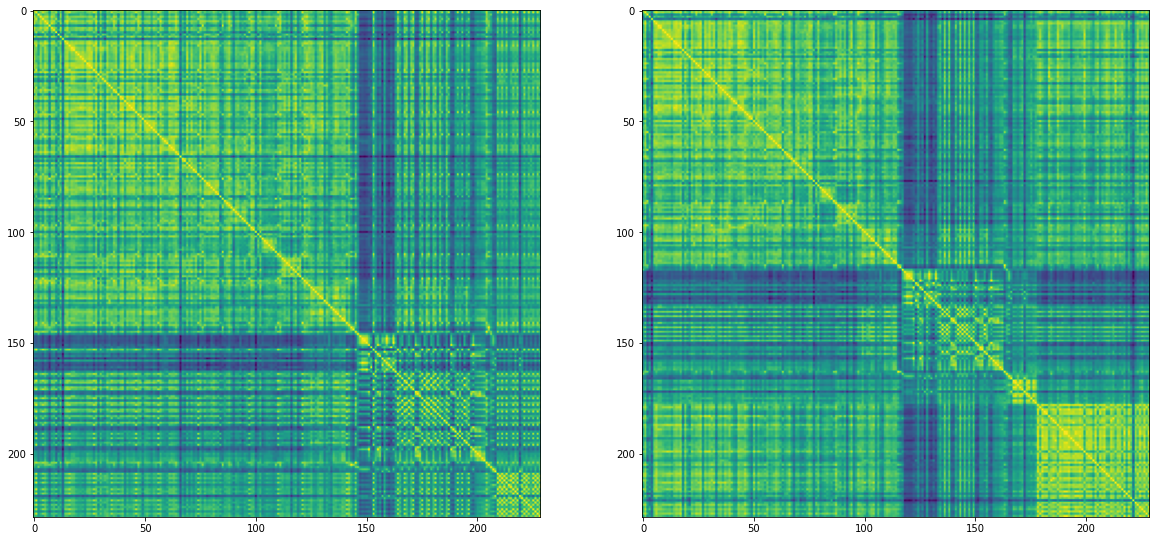

In [23]:
file =  src + 'train/0001daf4c2c76d.json'
notebook_df = pd.read_json(file,
                            dtype={'cell_type': 'category', 'source': 'str'}
                            ).rename_axis('cell_id')
true_table, cell_order = read_notebook_from_train_orders(str(file))
f, axs = plt.subplots(1,2,figsize=(20,15)) 
visualize_corr_matrix(true_table, axs, 0)
visualize_corr_matrix(notebook_df, axs, 1)

In [24]:
true_table

,cell_type,source
cell_id,,
97266564,markdown,comprehensive guide matplotlib seaborn plotly ...
a898e555,markdown,table content section importing matplotlib cla...
86605076,code,this python environment come with many helpful...
76cc2642,markdown,importing matplotlib just shorthand numpy shor...
ef279279,markdown,section section importing matplotlib classic g...
...,...,...
fdb8d575,code,data prepararion x2011 timesdata country times...
63625ef7,markdown,section thirtysix section plot plotly plot
16e57be6,code,data preparation x2015 timesdata timesdata yea...


In [25]:
notebook_df

,cell_type,source
cell_id,,
86605076,code,this python environment come with many helpful...
df6c939f,code,import matplotlib import matplotlib pyplot imp...
00f87d0a,code,matplotlib
986fd4f1,code,linspace figure plot plot savefig my_figure
9b761026,code,canvas get_supported_filetypes
...,...,...
996607a1,markdown,section twentynine section line chart plotly plot
60ffcfb7,markdown,plotly library plotly python graphing library ...
03a6fa77,markdown,section eighteen section joint plot using seaborn


In [26]:
### Functions to avaluate the result: ###

def count_inversions_slowly(ranks):
    inversions = 0
    size = len(ranks)
    for i in range(size):
        for j in range(i+1, size):
            if ranks[i] > ranks[j]:
                total += 1
    return total

from bisect import bisect

# Actually O(N^2), but fast in practice for our data
def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):  # O(N)
        j = bisect(sorted_so_far, u)  # O(log N)
        inversions += i - j
        sorted_so_far.insert(j, u)  # O(N)
    return inversions

def kendall_tau(ground_truth, predictions):
    total_inversions = 0  # total inversions in predicted ranks across all instances
    total_2max = 0  # maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max


# The first markdown in the very first cell
- 마크다운으로 시작하는 노트북의 경우 첫번째 마크다운셀의 내용이 대부분 아래와 같음
    - some greetings
    - desriptions of the following notebook
    - forks to another notebooks
- 이는 다음에 나올 코트셀과 큰 관련이 없음. 따라서 벡터공간에서 멀리있게 되고 모델은 이 첫번째 마크다운셀의 위치를 알맞게 놓지 못함
- 저자는 몇 가지 키워드를 지정하여 해당 키워드가 들어있는 마크다운 셀을 첫번째 마크다운셀이라하고 해당 키워드로 내용을 대신함


In [27]:
train_orders = pd.read_csv(src + 'train_orders.csv')
first_markdowns = []

for i in tqdm(range(N)):
    id_, cell_order = train_orders.iloc[i]
    cell = (cell_order.split(' ')[0])
    first_cell = (pd.read_json(src + 'train/' + id_ + '.json').loc[cell])
    if first_cell.cell_type == 'markdown':
        first_markdowns.append(first_cell.source)
        
print(len(first_markdowns))
first_markdowns[:5]

100%|██████████| 1500/1500 [00:24<00:00, 60.35it/s]

982


['## Note : This Kernel is a Fork from the amazing Kernel below . So please upvote the original Kernel . I have started adding few information and preprocessing into this on my own . \nhttps://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda',
 '#                                    Comprehensive Guide to--Matplotlib / Seaborn / Plotly\n\nMatplotlib is a multiplatform data visualization library built on NumPy arrays, and\ndesigned to work with the broader SciPy stack.One of Matplotlib’s most important features is its ability to play well with many operating systems and graphics backends. Matplotlib supports dozens of backends and\noutput types, which means you can count on it to work regardless of which operating\nsystem you are using or which output format you wish.',
 'Hi there,\n\nIs it ok that the same measurement have different target labels between signals?\nAccording to data description it should be the same (or not really?) . There are 38 cases of measurements wit

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=2,
        random_state=1).generate(str(data))
    fig = plt.figure(1, figsize=(18, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

Word cloud for markdowns in the very beginning of notebooks:


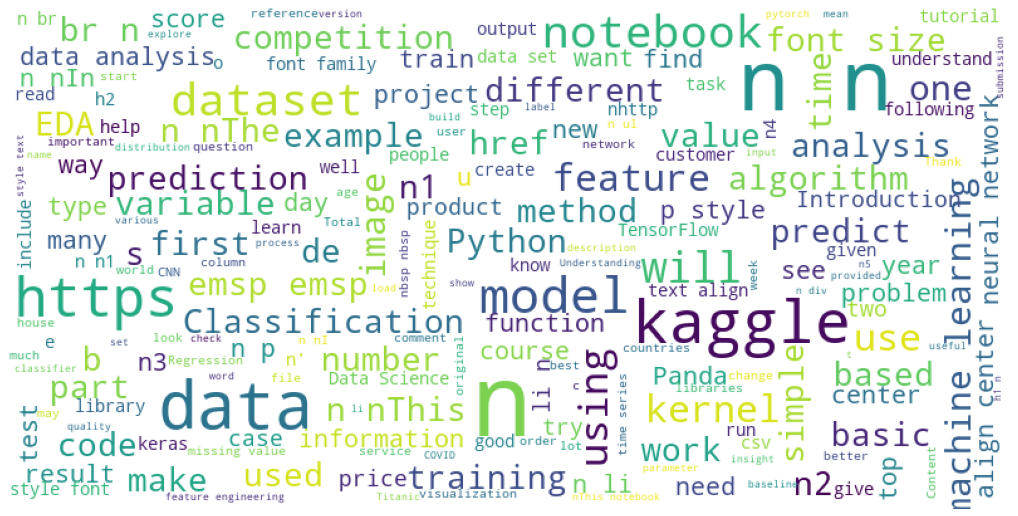

In [29]:
print("Word cloud for markdowns in the very beginning of notebooks:")
show_wordcloud(first_markdowns)

In [30]:
serch_list = ['hello', 'kagglers', 'this notebook', 'kaggle', 'welcome', 
              'competition', 'kernel', 'introduction', 'data analysis', 
              'https', 'data science', 'nbsp'] # These words almost sure stands in the markdowns at the very beginning of a notebook

In [31]:
def find_first_markdown(df):
    """
    This function finds a cell that should stand in the very beginning of notebooks
    retunrs cell index and a key word
    """
    table = df[df.cell_type == 'markdown']
    for word in serch_list:
        for i, line in enumerate(table.source):
            if re.search(word, line.lower()):
                return table.index[i], word
    return None, None

In [32]:
find_first_markdown(notebook_df)

('ae93e8e6', 'kernel')

In [33]:
notebook_df.loc['ae93e8e6'].source

'plotting from ipython notebook ipython notebook browser based interactive data analysis tool that bine narrative code graphic html element much more into single cutable document plotting interactively within ipython notebook done with matplotlib command work similar ipython shell ipython notebook also have option embedding graphic directly notebook with possible option matplotlib notebook will lead interactive plot embedded within notebook matplotlib inline will lead static image your plot embedded notebook this book will generally matplotlib inline matplotlib inline after this command need done only once kernel session cell within notebook that creates plot will embed image resulting graphic'

# Example below shows how we can find such markdown from dataframe
## Markdown "This notebook illustrate how to speedup..." should definitely stay in the beginning

In [34]:
df = pd.read_json(test_files[2])
cell, word = find_first_markdown(df)
print(cell, word, end='\n\n')
# df.tail(1)
print(df.loc[cell].source)

7f270e34 this notebook

This notebook illustrate how to speedup inference by :

    - sort input text from decreasing length
    
    - each batch has samples of similar token lengths. we pad each sample to the longest length in the batch.
    
since most of the input text are short, this method significantly speedup inference when compared to methdos that uses long fxied length padding.

make sure you will have to train your model to be robust against different length input. (which shouldn't be an issue since transformer has input attention mask)

with this code, i can run3x deberta-xlarge and 2x deberta-large model  (total 5 models) in under 3 hrs on the kaggle test set.
    


# Main algorithm

In [35]:
def overall_algo(file, to_check=False, to_plot = False, train = False):
    """
    This is the main sorting algorithm
    It computes matrix of cosine distance between cells in a vector space, 
    and than it sorts them by finding the perfect matches between markdown and code cells
    returns the cell order
    """
    
    # 재배열하지 않은 주어진 데이터
    # source에 있는 text를 모델을 통해 embedding
    # -> cosine similarity 계산
    df = (pd.read_json(file))
    df.source = df.source.apply(preprocess_text)
    vectors = []

    for i in range(len(df)):
        sentence = df.source[i]
#         sentence = preprocess_text(sentence)
        vector = model.get_sentence_vector(sentence)
        vectors.append(vector)

    matrix = cosine_similarity(vectors, vectors)
    
    if to_plot:
        f, axs = plt.subplots(1,3,figsize=(21,7)) # if you try the algo on a train dataset with true cell order
        #f, axs = plt.subplots(1,2,figsize=(20,10)) # if you try the algo on a test dataset you have just two graphs
        #axs[0].figure(figsize=(8,8))
        axs[0].imshow(matrix)
        axs[0].title.set_text('Initial Table')

    
    
    #id_ = file.split('/')[-1][:-5]
    if train:
        true_table, cell_order = read_notebook_from_train_orders(str(file)) # 순서대로 재배열된 데이터

    if to_plot:
        visualize_corr_matrix(true_table, axs, 2)
        axs[2].title.set_text('True Table')
     
    
    indexes_code = list(df[df.cell_type == 'code'].index)
    indexes_markdown = list(df[df.cell_type == 'markdown'].index)

    result = indexes_code.copy()

    N = len(indexes_code)
    K = len(indexes_markdown)

#     order = dict.fromkeys(np.arange(K))



    #### ALGORITHM WORKABLE #########

    markdowns_submatrix = matrix[N:,:-K].copy() # code cell과 markdown cell의 cosine similarity만 추출
    order = dict.fromkeys(np.arange(K))
    indexes_to_order = list(np.arange(K))

    # find the markdown in the very beginning of the notebook and place it there
    cell, word = find_first_markdown(df)
    if cell != None:
        idx = indexes_markdown.index(cell)
        order[idx] = 0 # 해당 마크다운 셀의 순서를 가장 앞으로 보냄
        markdowns_submatrix[idx] = np.zeros(N)
        indexes_to_order.remove(idx)
        
        
    initial_markdowns_submatrix = markdowns_submatrix.copy()

    for i in range(K):
        for i in range(K):
            if i in indexes_to_order:
                most_similar_code = np.argmax(markdowns_submatrix[i]) # i번째 마크다운 셀과 가장 cosine similarity가 높은 code cell 
                most_similar_markdown = np.argmax(markdowns_submatrix.T[most_similar_code])
                if most_similar_markdown == i:
                    #print(i, ' congrats')
                    order[i] = most_similar_code
                    indexes_to_order.remove(i)
                    markdowns_submatrix[most_similar_markdown] = np.zeros(N)  
                    markdowns_submatrix[:, most_similar_code] = np.zeros(K)
        if (np.max(markdowns_submatrix) == 0): # stop creteria - all cells are sorted
            break
        markdowns_submatrix_old = markdowns_submatrix.copy()


    # if some markdowns left (number of markdown cells is greater than codes) - 마크다운셀이 코드셀보다 많은 경우
    for key, value in zip(indexes_to_order, np.argmax(initial_markdowns_submatrix[indexes_to_order], axis=1)):
        order[key] = value 

#     indexes_code = list(df[df.cell_type == 'code'].index)
#     indexes_markdown = list(df[df.cell_type == 'markdown'].index)

#     result = indexes_code.copy()

    for i in range(K-1, -1, -1):
        markdown_cell = indexes_markdown[i]
        corresponding_code_cell = indexes_code[order[i]]
        new_index = result.index(corresponding_code_cell)
        result.insert(new_index, markdown_cell)

    if to_check:
        print("Algorithm: ")
        check(result, file)
        print("True notebook: ")
        #table, gt = read_notebook_from_train_orders(id_)
        display(true_table)
        
    if to_plot:
        visualize_corr_matrix(df.loc[result], axs, 1)
        axs[1].title.set_text('My Result')
    return result

72 21
2e94bd7a kaggle
14
{0: None, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: 0, 15: None, 16: None, 17: None, 18: None, 19: None, 20: None}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
0
6 0
{0: 6, 1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: 0, 15: None, 16: None, 17: None, 18: None, 19: None, 20: None}
1
4 1
{0: 6, 1: 4, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: 0, 15: None, 16: None, 17: None, 18: None, 19: None, 20: None}
2
5 11
3
15 10
4
14 4
{0: 6, 1: 4, 2: None, 3: None, 4: 14, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: 0, 15: None, 16: None, 17: None, 18: None, 19: None, 20: None}
5
33 10
6
32 10
7
3 7
{0: 6, 1: 4, 2: None, 3: None, 4: 14, 5: None, 6: None, 7: 3, 8: None, 9:

,cell_type,source
cell_id,,
da4f7550,markdown,## import modules and define models
2e94bd7a,markdown,## Note : This Kernel is a Fork from the amazi...
c417225b,code,import numpy as np # linear algebra\nimport pa...
51e3cd89,code,"input_dir = ""../input/"""
2600b4eb,code,"train_df = pd.read_csv(""../input/train.csv"")\n..."
657a8804,markdown,## images with defect(label: 1)
75b65993,code,class_dict = defaultdict(int)\n\nkind_class_di...
cd61f6d1,markdown,## images with defect(contain 3 type label)
cf195f8b,code,"print(""the number of images with no defects: {..."


True notebook: 


,cell_type,source
cell_id,,
2e94bd7a,markdown,note this kernel fork from amazing kernel belo...
3e99dee9,markdown,about competition detecting steel defect steel...
b5e286ea,markdown,reference http faculty yunhyan neu_surface_def...
da4f7550,markdown,import module define model
c417225b,code,import numpy linear algebra import panda set_o...
51e3cd89,code,input_dir input
2600b4eb,code,train_df read_csv input train sample_df read_c...
75b65993,code,class_dict defaultdict kind_class_dict default...
cf195f8b,code,print number image with defect format no_defec...


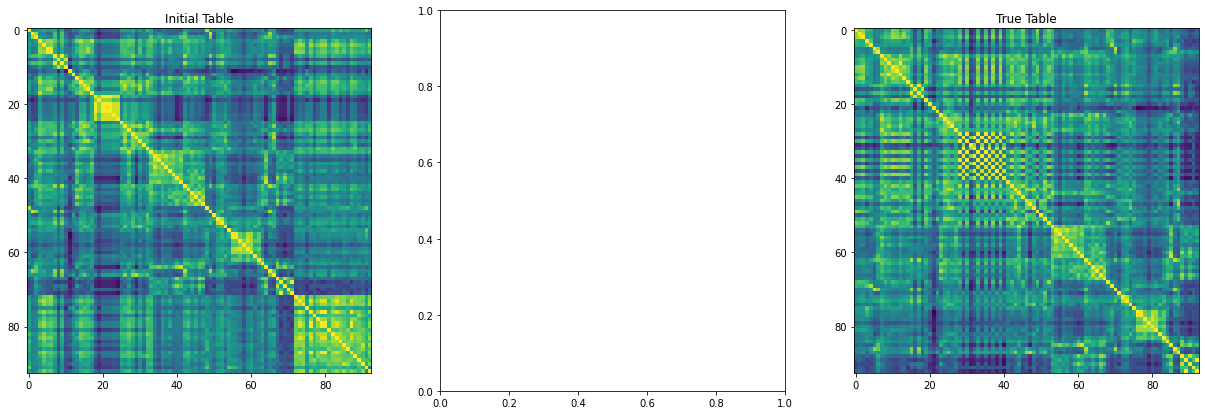

In [36]:
# file = '../input/AI4Code/train/00035108e64677.json'
file = '../input/AI4Code/train/00015c83e2717b.json'
df = (pd.read_json(file))
df.source = df.source.apply(preprocess_text)
vectors = []

for i in range(len(df)):
    sentence = df.source[i]
#         sentence = preprocess_text(sentence)
    vector = model.get_sentence_vector(sentence)
    vectors.append(vector)

matrix = cosine_similarity(vectors, vectors)
    
    
    
true_table, cell_order = read_notebook_from_train_orders(str(file))




f, axs = plt.subplots(1,3,figsize=(21,7)) # if you try the algo on a train dataset with true cell order
#f, axs = plt.subplots(1,2,figsize=(20,10)) # if you try the algo on a test dataset you have just two graphs
#axs[0].figure(figsize=(8,8))
axs[0].imshow(matrix)
axs[0].title.set_text('Initial Table')

visualize_corr_matrix(true_table, axs, 2)
axs[2].title.set_text('True Table')
    
    
indexes_code = list(df[df.cell_type == 'code'].index)
indexes_markdown = list(df[df.cell_type == 'markdown'].index)

result = indexes_code.copy()

N = len(indexes_code)
K = len(indexes_markdown)
print(N, K)


markdowns_submatrix = matrix[N:,:-K].copy() # code cell과 markdown cell의 cosine similarity만 추출
# markdowns_submatrix
order = dict.fromkeys(np.arange(K))
indexes_to_order = list(np.arange(K))

cell, word = find_first_markdown(df)
print(cell, word)
if cell != None:
    idx = indexes_markdown.index(cell)
    print(idx)
    order[idx] = 0 # 해당 마크다운 셀의 순서를 가장 앞으로 보냄
    print(order)
    markdowns_submatrix[idx] = np.zeros(N)
    indexes_to_order.remove(idx)
    print(indexes_to_order)
    
initial_markdowns_submatrix = markdowns_submatrix.copy()

for i in range(K):
    for i in range(K):
        print(i)
        if i in indexes_to_order:
            most_similar_code = np.argmax(markdowns_submatrix[i]) # i번째 마크다운 셀과 가장 cosine similarity가 높은 code cell 
            most_similar_markdown = np.argmax(markdowns_submatrix.T[most_similar_code])
            print(most_similar_code, most_similar_markdown)
            if most_similar_markdown == i:
                #print(i, ' congrats')
                order[i] = most_similar_code
                print(order)
                indexes_to_order.remove(i)
                markdowns_submatrix[most_similar_markdown] = np.zeros(N)
                markdowns_submatrix[:, most_similar_code] = np.zeros(K)
    if (np.max(markdowns_submatrix) == 0): # stop creteria - all cells are sorted
        break
        
    markdowns_submatrix_old = markdowns_submatrix.copy()

# if some markdowns left (number of markdown cells is greater than codes) - 마크다운셀이 코드셀보다 많은 경우
for key, value in zip(indexes_to_order, np.argmax(initial_markdowns_submatrix[indexes_to_order], axis=1)):
    order[key] = value
    print(order)


print('new_index', len(result))
for i in range(K-1, -1, -1):
    print(i)
    markdown_cell = indexes_markdown[i]
    corresponding_code_cell = indexes_code[order[i]]
    new_index = result.index(corresponding_code_cell)
    print(markdown_cell, order[i], corresponding_code_cell, new_index)
    result.insert(new_index, markdown_cell) # 유사도가 가장 높은 코드셀앞에 마크다운셀 insert
    print(len(result))

print(len(result))


print("Algorithm: ")
check(result, file)
print("True notebook: ")
#table, gt = read_notebook_from_train_orders(id_)
display(true_table)
        
#     if to_plot:
#         visualize_corr_matrix(df.loc[result], axs, 1)
#         axs[1].title.set_text('My Result')
#     return result

# An example of algorithm with graph:

Algorithm: 


,cell_type,source
cell_id,,
0f08a082,markdown,# Market Value Prediction\n\n#### Welcome to F...
fc3c6029,markdown,# Import the dependencies
1087237d,code,# Data manipulation\nimport pandas as pd\nimpo...
d76d8be7,markdown,# Get the data
d7209f1f,code,fifa_raw_dataset = pd.read_csv('../input/data....
daf5b8ee,code,fifa_raw_dataset.head()
e404213c,code,fifa_raw_dataset.info()
2bad59b0,code,fifa_raw_dataset.shape
4cdd8d14,markdown,# Feature Selection\n#### Based on my intuitio...


True notebook: 


,cell_type,source
cell_id,,
0f08a082,markdown,market value prediction welcome fifa task pred...
fc3c6029,markdown,import dependency
1087237d,code,data manipulation import panda import numpy da...
d76d8be7,markdown,data
d7209f1f,code,fifa_raw_dataset read_csv input data
c6599912,markdown,take look data datastructure
daf5b8ee,code,fifa_raw_dataset head
e404213c,code,fifa_raw_dataset info
2bad59b0,code,fifa_raw_dataset shape


score = 0.874120082815735


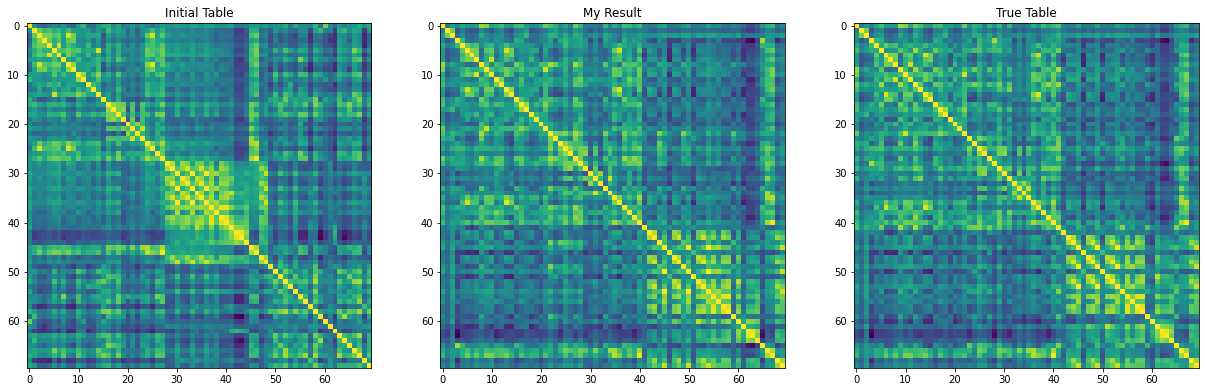

In [37]:
file =  src + 'train/0001daf4c2c76d.json'
file =  src + 'train/000bbb79a2fe3c.json' # not bad
file =  src + 'train/000c0a9b2fef4d.json' # far not bad


predictions = overall_algo(file, to_check = True, to_plot = True, train = True)
true_table, ground_truth = read_notebook_from_train_orders(str(file))
score = kendall_tau([ground_truth], [predictions])
print(f"score = {score}")

# Accuracy = 87% for table of 70 rows with 21 markdowns

In [38]:
true_table, ground_truth = read_notebook_from_train_orders(str(file))
score = kendall_tau([ground_truth], [predictions])
print(f"score = {score}")

score = 0.874120082815735


In [39]:
df = (pd.read_json(file))
len(df), len(df[df.cell_type == 'markdown'])

(70, 21)

# Accuracy evaluation

In [40]:
def compare_algo_with_gt(file, to_check=True):
    id_ = file.split('/')[-1][:-5]
    if to_check:
        print(i, file, id_)
        print("Algorithm: ")
    algo_result = overall_algo(file, to_check=to_check)
    if to_check:
        print("True notebook: ")
    table, gt = read_notebook_from_train_orders(file)
    if to_check:
        display(table)
    return algo_result, gt

In [41]:
train_dir = '../input/AI4Code/train/'
train_files = os.listdir(train_dir)

In [42]:
predictions = []
ground_truth = []

N=1500

for i in tqdm(range(N)):
    file = train_dir + train_files[i]
    algo_result, cell_order = compare_algo_with_gt(file, to_check=False)
    ground_truth.append(cell_order)
    predictions.append(algo_result)

final_score = kendall_tau(ground_truth, predictions)
print(f"the accuracy on {N/14000}% of the data is {round(final_score, 3)}")

100%|██████████| 1500/1500 [02:00<00:00, 12.49it/s]


the accuracy on 0.10714285714285714% of the data is 0.705


## 71.8% for now

In [43]:
# submission 파일 생성

df_result = pd.DataFrame(columns = ['id', 'cell_order'])
#df_example = pd.read_csv(src + 'sample_submission.csv')

for i, file in enumerate(test_files):
    print(i, file)
    id_ = str(test_files[i]).split('/')[-1][:-5]
    df = pd.read_json(file)
    example = df.index.tolist()
    result = overall_algo(file)
    try:
        result = overall_algo(file)
        if len(result) != len(df):
            result = ' '.join(example) #df_example.cell_order[i] # if result is weird (can't imagine how it's possible)
        elif (len(set(result) - set(example)) != 0) or (len( set(example) - set(result) ) != 0 ):
            result = ' '.join(example) #df_example.cell_order[i]
        else:
            result = ' '.join(result)
    except:
        result = ' '.join(example) # if algo failed put from example # never happened but just in case to avoid submission error 
      
    to_add = result
    df_result = df_result.append({'id':id_, 'cell_order':to_add}, ignore_index=True)

df_result


0 ../input/AI4Code/test/0009d135ece78d.json
1 ../input/AI4Code/test/0028856e09c5b7.json
2 ../input/AI4Code/test/0010483c12ba9b.json
3 ../input/AI4Code/test/0010a919d60e4f.json


,id,cell_order
0,0009d135ece78d,0a226b6a ddfd239c 8cb8d28a c6cd22db 1372ae9b b...
1,0028856e09c5b7,eb293dfc 012c9d02 d22526d1 3ae7ece3
2,0010483c12ba9b,7f270e34 54c7cab3 fe66203e 7844d5f8 5ce8863c 4...
3,0010a919d60e4f,b7578789 4ae17669 aafc3d23 52fe98c4 80e077ec 5...


In [44]:
df_result.to_csv('submission.csv', index = False)

In [45]:
#cat submission.csv